In [1]:
from __future__ import print_function
from fenics import *
import numpy as np
import scipy
import random
import matplotlib.pyplot as plt
import copy
%matplotlib inline
from DLR import DLR2
from DLR import DLR
from DLR import DLR3
from Two_level_DLR import Two_level_DLR
from Multi_Level_DLR import Multi_Level_DLR


In [2]:
def l2_error(u,v):
    return assemble((u-v)*(u-v)*dx)
#     return assemble((u-v)*dx)


def Ans(t):
#     Ans = []
#     for i in range(sample_size): 
#         expression_terms = ""
#         for i in range(1, 6):
#             term1 = f"exp(-xi * pow(pi * {i}, 2) * t) * sin(pi * {i} * x[0]) + "
#             term2 = f"exp(-xi * pow(pi * ({i} + 100), 2) * t) * sin(pi * ({i} + 100) * x[0]) + "
#             expression_terms += term1
#             expression_terms += term2
#         expression_terms = expression_terms[:-3]
#         expr = Expression(expression_terms, degree=30, xi=xi[i],t=Constant(t))
#         Ans.append(expr)
#     return Ans
    Ans = []
    for i in range(sample_size): 
        expression_terms = "exp(-xi * pow(pi * 1, 2) * t) * xi2 * sin(pi * 1 * x[0]) + exp(-xi2 * pow(pi * 2, 2) * t) * xi3 * sin(pi * 2 * x[0]) + exp(-xi2 * pow(pi * 3, 2) * t) * xi4 * sin(pi * 3 * x[0]) + exp(-xi2 * pow(pi * 4, 2) * t) *xi5 *  sin(pi * 4 * x[0]) + exp(-xi2 * pow(pi * 5, 2) * t) * xi6* sin(pi * 5 * x[0]) + exp(-xi3* pow(pi * (1 + 100), 2) * t) * xi7 * sin(pi * (1 + 100) * x[0]) + exp(-xi3* pow(pi * (2 + 100), 2) * t) * xi8 * sin(pi * (2 + 100) * x[0]) + exp(-xi3* pow(pi * (3 + 100), 2) * t) * xi9 * sin(pi * (3 + 100) * x[0]) + exp(-xi3* pow(pi * (4 + 100), 2) * t) * xi10* sin(pi * (4 + 100) * x[0]) + exp(-xi3* pow(pi * (5 + 100), 2) * t) * xi11 * sin(pi * (5 + 100) * x[0])"
        expr = Expression(expression_terms, degree=30, xi=xi[i],xi2 = xi2[0][i],xi3 = xi2[1][i],xi4 = xi2[2][i],xi5 = xi2[3][i],xi6 = xi2[4][i],xi7 = xi2[0][i],xi8 = xi2[1][i],xi9 = xi2[2][i],xi10 = xi2[3][i],xi11 = xi2[4][i],t=Constant(t))
        Ans.append(expr)
    return Ans


In [8]:
sample_size = 50
# xi = np.random.uniform(low=1, high=2, size=(sample_size))
# xi2  = np.random.uniform(low=1, high=2, size=(10,sample_size))
xi2  = np.random.uniform(low=1, high=2, size=(5,sample_size))
xi = xi2[0]
dt_list=[]
dh_list=[]
error_list = []

U0 = [Expression(f"sin(pi*{i}*x[0])", degree=10) for i in range(1,6)]
U1 =  [Expression(f"sin(pi*({i}+100)*x[0])", degree=10) for i in range(1,6)]

U = U0 + U1
a_0 = Constant(0)
a = []
a_sto = []
for i in range(sample_size):
    a.append(Constant(xi[i]))
    a_sto.append(Constant(xi[i]))
# Y = list(np.ones((10,sample_size)))
Y = list(xi2) + list(xi2)

# str = ""
# for i in range(1,6):
#     str += f"sin(pi*{i}*x[0]) + sin(pi*({i}+100)*x[0]) + "
# str =str[:-3]
# YU = [Expression(str,degree = 10)  for i in range (sample_size)]

YU = Ans(0)

In [4]:
class DLR2_test(DLR2):
    def explicit_simulate(self,end = 2.5):
        t = 0
        count = 0 # calculate energynorm each step is cotly so only every some steps
        self.timelist.append(t)
        
        u2 = []
        for i in range(sample_size):
            func = Constant(0)
            for j in range(self.R):
                func +=self.U[j] * Constant(self.Y[j][i]) 
            u2.append(func)
        error2 = 0
        for i in range(sample_size):
            error2 += l2_error(Ans(0)[i],u2[i])
        self.L2list.append(error2/self.sample_size)
        # Define variational problem
        
        for i in range(self.R):
            self.U[i] = TrialFunction(self.V)
        v = TestFunction(self.V)

        lhs = []
        rhs = []
        for i in range(self.R):
            a_i = self.U[i] * v * dx
            L_i = self.U_n[i] * v * dx - self.dt * dot(self.E_a_grad_u_Y(self.a,self.Y[i]), grad(v)) * dx
            lhs.append(a_i)
            rhs.append(L_i)
           
        for i in range(self.R):
            self.U[i] = Function(self.V)
        
        while t < end:           
            # Compute solution
            for i in range(self.R):
                solve(lhs[i]==rhs[i],self.U[i],self.bc)
         
            self.matrix_calculate()

            A = []
            for i in range(self.R):
                A.append(self.orthogonal_projection(self.a_grad_u_grad_U(self.a)[i]))
            A = np.array(A)
            det = np.linalg.det(self.matrix)
            if np.isclose(det, 0):
                self.Y += -self.dt * scipy.linalg.lstsq(self.matrix,A)[0]
            else:
                self.Y += -self.dt * scipy.linalg.solve(self.matrix,A)
        
            
            # reorthogonalize
            self.reorthogonalize()

            t  += self.dt
            count += 1
            
            for i in range(self.R):
                self.U_n[i].assign(self.U[i])
           
            if count % 1 == 0:
                u2 = []
                for i in range(sample_size):
                    func = Constant(0)
                    for j in range(self.R):
                        func += self.U[j] * Constant(self.Y[j][i]) 
                    u2.append(func)
                error2 = 0
                for i in range(sample_size):
                    error2 += l2_error(Ans(t)[i],u2[i])
                self.L2list.append(error2/self.sample_size)
                self.timelist.append(t)

In [5]:
class Two_level_DLR_test(Two_level_DLR):
      def explicit_simulate(self,end = 2.5):
        t = 0
        count = 0 # calculate energynorm each step is cotly so only every some steps
        self.timelist.append(t)

        u1 = []
        for i in range(self.sample_size):
            func = Constant(0)
            for j in range(self.R_f):
                func += (self.delta_f[j] * Constant(self.Y_f[j][i]) )
            for j in range(self.R_c):
                func += (interpolate(self.delta_c_n[j] ,self.V_f)* Constant(self.Y_c[j][i]) )
            u1.append(func)     
        error = 0
        for i in range(self.sample_size):
            error += l2_error(Ans(t)[i],u1[i])     
        self.L2list.append(error/self.sample_size)
        

        # Define variational problem
        
        for i in range(self.R_f):
            self.delta_f[i] = TrialFunction(self.V_f)
        v_f = TestFunction(self.V_f)
        
        for i in range(self.R_c):
            self.delta_c[i] = TrialFunction(self.V_c)
        v_c = TestFunction(self.V_c)

        lhs_f = []
        rhs_f = []
        lhs_c = []
        rhs_c = []
        
        for i in range(self.R_c):
            a_i = self.delta_c[i] * v_c * dx
            L_i = self.delta_c_n[i] * v_c* dx - self.dt * dot(self.E_a_grad_u_Y(self.a,self.Y_c[i],cf= "c"), grad(v_c)) * dx
            lhs_c.append(a_i)
            rhs_c.append(L_i)
           
        for i in range(self.R_c):
            self.delta_c[i] = Function(self.V_c)
        
        for i in range(self.R_f):
            a_i = self.delta_f[i] * v_f * dx
            L_i = self.delta_f_n[i] * v_f * dx - self.dt * dot(self.E_a_grad_u_Y(self.a,self.Y_f[i],cf= "f"), grad(v_f)) * dx
            lhs_f.append(a_i)
            rhs_f.append(L_i)
           
        for i in range(self.R_f):
            self.delta_f[i] = Function(self.V_f)
        
        while t < end:           
            # Compute solution
            for i in range(self.R_c):
                solve(lhs_c[i]==rhs_c[i],self.delta_c[i],self.bc_c)
            
            self.matrix_calculate_c()

            A_c = [self.orthogonal_projection_c(self.a_grad_u_grad_U(self.a, cf="c")[i]) for i in range(self.R_c)]
            A_c = np.array(A_c)
            det = np.linalg.det(self.matrix_c)
            if np.isclose(det, 0):
                self.Y_c += -self.dt * scipy.linalg.lstsq(self.matrix_c,A_c)[0]
            else:
                self.Y_c += -self.dt * scipy.linalg.solve(self.matrix_c,A_c)
               
            
            
            
            for i in range(self.R_f):
                solve(lhs_f[i]==rhs_f[i],self.delta_f[i],self.bc_f)
           
            self.matrix_calculate_f()
           
            A_f = [self.orthogonal_projection_f(self.a_grad_u_grad_U(self.a, cf="f")[i]) for i in range(self.R_f)]
            
            A_f = np.array(A_f)
            det = np.linalg.det(self.matrix_f)
            if np.isclose(det, 0):
                self.Y_f += -self.dt * scipy.linalg.lstsq(self.matrix_f,A_f)[0]
            else:
                self.Y_f += -self.dt * scipy.linalg.solve(self.matrix_f,A_f)
              
            # reorthogonalize
            self.reorthogonalize_c()
            
            self.reorthogonalize_f()
           
            t  += self.dt
            count += 1
            
            for i in range(self.R_c):
                self.delta_c_n[i].assign(self.delta_c[i])
            for i in range(self.R_f):
                self.delta_f_n[i].assign(self.delta_f[i])
            self.Y_c_n = self.Y_c
           
            if count % 1 == 0:
                self.timelist.append(t)
                u1 = []
                for i in range(self.sample_size):
                    func = Constant(0)
                    for j in range(self.R_f):
                        func += (self.delta_f[j] * Constant(self.Y_f[j][i]) )
                    for j in range(self.R_c):
                        func += (interpolate(self.delta_c_n[j] ,self.V_f)* Constant(self.Y_c[j][i]) )
                    u1.append(func)     
                error = 0
                for i in range(self.sample_size):
                    error += l2_error(Ans(t)[i],u1[i])     
                self.L2list.append(error/self.sample_size)


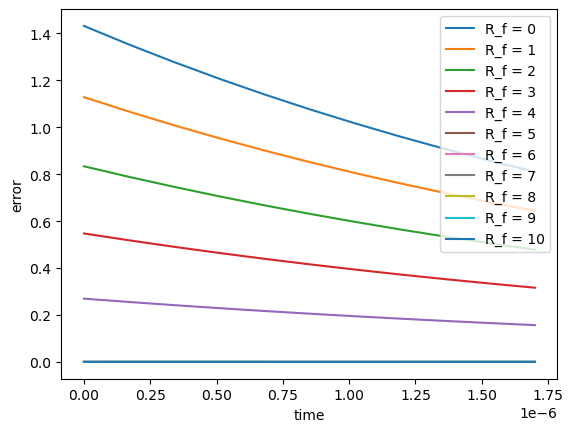

In [87]:
for i in range(len(error_list)):
    plt.plot(time_list[0], error_list[i])
plt.xlabel("time")
plt.ylabel("error")
plt.legend(['R_f = 0','R_f = 1','R_f = 2','R_f = 3','R_f = 4','R_f = 5','R_f = 6','R_f = 7','R_f = 8','R_f = 9','R_f = 10'])
plt.show()

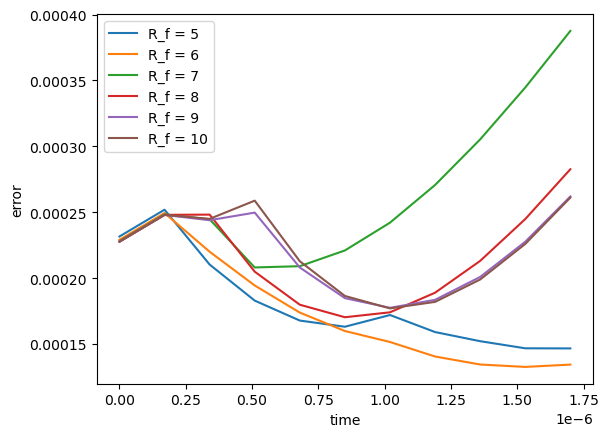

In [99]:
for i in range(5,len(error_list)):
    plt.plot(time_list[0], error_list[i])
plt.xlabel("time")
plt.ylabel("error")
plt.legend(['R_f = 5','R_f = 6','R_f = 7','R_f = 8','R_f = 9','R_f = 10'])
plt.show()


In [ ]:
time_list=[]
error_list=[]
random_heat = DLR2_test(dt =  0.000000017,n = 128,a = a,a_0 = a_0,a_sto = a_sto,R =10  ,sample_size = sample_size,mesh_type='1D',U = U, Y = Y)
random_heat.explicit_simulate(end=0.000000084999)
time_list.append(random_heat.timelist)
error_list.append(random_heat.L2list)
print(time_list)
print(error_list)
for R_f in range(1,10):
    random_heat = Two_level_DLR_test(dt = 0.000000017,n_f=1024,n_c=128,R_c=10-R_f,R_f=R_f,mesh_type='1D',sample_size = sample_size,delta_c=U[:10-R_f],delta_f=U[-R_f:],Y_c =Y[:10-R_f],Y_f=Y[-R_f:],YU =YU,a=a,a_0=a_0,a_sto=a_sto)
    random_heat.explicit_simulate(end=0.000000084999)
    error_list.append(random_heat.L2list)
    print(error_list)
random_heat = DLR2_test(dt =  0.000000017,n = 1024,a = a,a_0 = a_0,a_sto = a_sto,R =10  ,sample_size = sample_size,mesh_type='1D',U = U, Y = Y)
random_heat.explicit_simulate(end=0.000000084999)
error_list.append(random_heat.L2list)
print(error_list)

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

In [ ]:
for i in (0,5,10):
    plt.plot(time_list[0], error_list[i])
plt.xlabel("time")
plt.ylabel("L2 error")
plt.legend(['R_f = 0','R_f = 5','R_f = 10'])
plt.show()

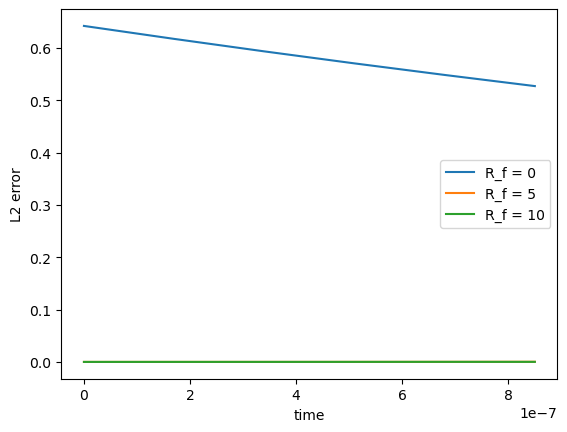

In [231]:
for i in (0,5,10):
    plt.plot(time_list[0], error_list[i])
plt.xlabel("time")
plt.ylabel("L2 error")
plt.legend(['R_f = 0','R_f = 5','R_f = 10'])
plt.show()

In [8]:
R_f = 3
random_heat3 = Two_level_DLR_test(dt = 0.00000017,n_f=1024,n_c=128,R_c=10-R_f,R_f=R_f,mesh_type='1D',sample_size = sample_size,delta_c=U[:10-R_f],delta_f=U[-R_f:],Y_c =Y[:10-R_f],Y_f=Y[-R_f:],YU = YU,a=a,a_0=a_0,a_sto=a_sto)
u1 =[]
for i in range(random_heat3.sample_size):
    func = Constant(0)
    for j in range(random_heat3.R_f):
        func += (random_heat3.delta_f[j] * Constant(random_heat3.Y_f[j][i]) )
    for j in range(random_heat3.R_c):
        func += (interpolate(random_heat3.delta_c_n[j] ,random_heat3.V_f)* Constant(random_heat3.Y_c[j][i]) )
    u1.append(func)
error = 0
for i in range(sample_size):
    error += l2_error(Ans(0)[i],u1[i])
print(error/sample_size)

[[ 1.00000000e+00  4.90786401e-18 -1.90502441e-17  1.13669824e-17
   9.53063275e-17 -6.06716908e-17 -3.24975627e-17]
 [ 4.90786401e-18  1.00000000e+00 -6.73055504e-18 -3.72966557e-17
  -8.01210628e-17  2.10725599e-17 -3.26807572e-17]
 [-1.90502441e-17 -6.73055504e-18  1.00000000e+00 -1.74169560e-17
  -1.74417171e-18 -1.15790385e-17 -9.87924619e-18]
 [ 1.13669824e-17 -3.72966557e-17 -1.74169560e-17  1.00000000e+00
  -1.24618949e-16  6.83157345e-17  1.70584755e-17]
 [ 9.53063275e-17 -8.01210628e-17 -1.74417171e-18 -1.24618949e-16
   1.00000000e+00  5.64130502e-17 -7.45456462e-17]
 [-6.06716908e-17  2.10725599e-17 -1.15790385e-17  6.83157345e-17
   5.64130502e-17  1.00000000e+00  7.19069754e-17]
 [-5.55111512e-17 -8.32667268e-17  1.73472348e-17  4.85722573e-17
  -7.45456462e-17  7.19069754e-17  1.00000000e+00]]
[[ 6.00000000e+01 -1.51022928e-16  2.66754543e-16  6.72406802e-16
   5.11268447e-15 -2.44261831e-15 -2.51580228e-15]
 [-1.51022928e-16  6.00000000e+01 -2.01568726e-15 -1.20632199e-

In [16]:
print(assemble(random_heat3.delta_c_n[0] * random_heat3.delta_c[4] * dx))
print(np.dot(random_heat3.Y_c[2],random_heat3.Y_c[2]))

-6.98700032766861e-18
2499.999999999996


In [7]:
random_heat3.explicit_simulate(end = 0.00000017)
random_heat3.L2list

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FF

[0.00047794603235535264, 0.000853571944109241]

In [75]:
random_heat3 = DLR2(dt =  0.000000017,n = 1024,a = a,a_0 = a_0,a_sto = a_sto,R =10  ,sample_size = sample_size,mesh_type='1D',U = U, Y = Y)
print(assemble(random_heat3.U[2] * random_heat3.U[2] * dx))
print(np.dot(random_heat3.Y[1],random_heat3.Y[0]))

0.11109221859948915
1.915134717478395e-15


In [9]:
random_heat = DLR2_test(dt =  0.000000017,n = 1024,a = a,a_0 = a_0,a_sto = a_sto,R =10  ,sample_size = sample_size,mesh_type='1D',U = U, Y = Y)
random_heat.explicit_simulate(end=0.000000085)
random_heat.L2list

Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear v

[0.00048031260056372813,
 0.0004733414249375842,
 0.0004729229674013016,
 0.0004792004631193088,
 0.0004920676281446542,
 0.0005114193914445813]

In [239]:
random_heat3.explicit_simulate(end = 0.0000017)

time:  0
energy norm:  381697.0752105691
L2 norm:  2.226201347250438
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
time:  1.7e-07
energy norm:  361248.2759783539
L2 norm:  2.1975059696853556
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


KeyboardInterrupt: 

In [ ]:
random_heat3 = Two_level_DLR_test(dt = 0.00000017,n_f=1024,n_c=128,R_c=2,R_f=2,mesh_type='1D',sample_size = sample_size,YU = YU ,a=a,a_0=a_0,a_sto=a_sto)
dd